In [1]:
include("state_utils.jl")

load_states (generic function with 1 method)

In [2]:
# Single patient file
p1 = JSON.parsefile(dpath * "patient_1.json")

Dict{String,Any} with 8 entries:
  "num_observations" => 74
  "mortality"        => true
  "patient_index"    => 1
  "actions"          => Any[21, 21, 1, 1, 1, 1, 1, 1, 1, 21  …  1, 1, 1, 1, 2, …
  "icuid"            => 200003
  "MAP"              => Any[83, 84.5, 68.2, 69.3333, 70, 73, 66, 68, 71, 72  … …
  "cont_actions"     => Any[Any[0.2245, 0.224, 0, 0, 0, 0, 0, 0, 0, 0.225  …  0…
  "trajectory"       => Any[Any[-0.359482, 0.439907, -1.05909, -0.487919, -0.17…

In [3]:
# Trajectory state size
size(p1["trajectory"][1])

(49,)

In [4]:
# State matrix, columns are 49-vectors of states
S = load_states()
size(S)

(49, 352328)

In [5]:
S = shuffle_cols(S)

49×352328 Array{Float64,2}:
  0.444369   -0.359482      0.444369   …  -0.359482   -0.359482    -0.359482
 -0.901947    0.359183      0.447624       0.244368    0.628324     0.494361
 -0.0427263  -1.05909       0.718856      -0.457158   -0.0427263   -0.236835
  0.218701   -0.785698      0.0146003     -0.345521   -0.945779    -0.414843
 -0.402714   -0.769629      0.190549      -0.428319   -0.537782    -0.50924
  0.0374578  -0.38182      -0.242061   …   0.27039    -0.242061    -0.614752
  0.38316    -1.00529       0.290653      -0.56654     0.193394    -0.13655
  0.113487   -0.610299     -0.310497      -0.610299   -0.310497    -0.310497
 -0.836867    0.0970069     0.216296       0.382756   -0.0676812   -0.359649
 -0.546496    0.00188715   -0.573668       0.358321   -0.120777     0.56555
  0.0373248  -0.107021     -0.618984   …   0.711805   -0.114148     0.191482
  0.378178    0.13617       0.13617        0.19889    -0.884231    -0.359437
 -0.243602    0.0647747    -0.461657      -0.461657

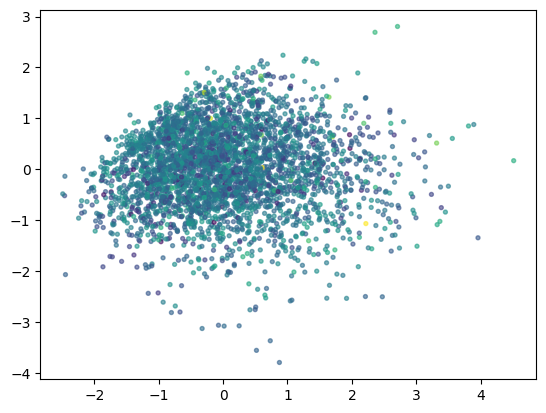

In [6]:
M = create_pca_matrix(S, at = 0.998, dims = 3)
_, srs = partition_dataset(S, at = 0.99)
    
# apply PCA model to testing set
y_te = reduce_dims(M, srs)

# reconstruct testing observations (approximately)
# test_2d = reconstruct(M, y_te)

scatter(y_te[1,:],y_te[2,:], c = y_te[3,:], s = 8, alpha = 0.6)
plt.show()

In [7]:
#
# we take about 20K states and pre-initialize clusters from them
#
_, opt      = partition_dataset(S, at = 0.95)
centroids   = k_means_pp(opt, n_states)

# now we call standard k-means
m_centroids = hcat(centroids...)
R           = kmeans!(S, m_centroids)

#
# create matrix for dimentionality reduction from 49 to 2 dimentions
# so that we can visualize our centroids
#
M = create_pca_matrix(S, at = 0.5, dims = 2)

PCA(indim = 49, outdim = 2, principalratio = 0.2124032281394201)

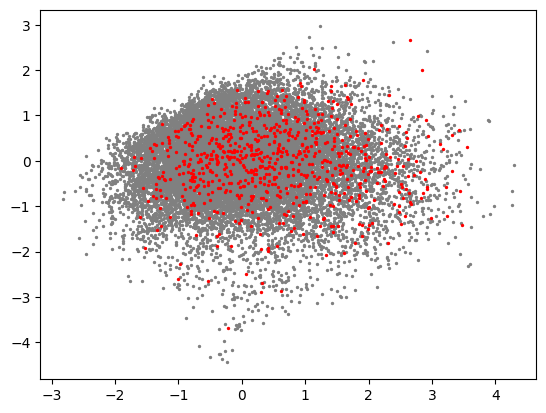

In [8]:
points     = reduce_dims(M, opt)
clusters2d = reduce_dims(M, m_centroids)

scatter(points[1,:], points[2,:], color = "gray", s = 2)
scatter(clusters2d[1,:], clusters2d[2,:], color = "red", s = 2)
plt.show()

In [9]:
state_vectors_file = apath * "state_vectors.json" 
save_state_vectors(state_vectors_file, m_centroids)

In [10]:
lvc = restore_state_vectors(state_vectors_file)

49×750 Array{Float64,2}:
 -0.232864   -0.359482    0.397083    …  -0.303399     0.277017
 -0.0260014   0.227875   -0.253791        0.085407     0.0345901
  0.0672445  -0.0427263  -0.215094        0.348456     0.102411
 -0.306601    0.553472    0.819391        0.306618     0.122776
 -0.299481    0.770682    0.735305        0.248489     0.115765
 -0.429854    0.27039     1.00207     …   0.240295     0.0169706
 -0.28756     0.38316     0.647007       -0.00456116   0.291724
  0.0742778   0.837272   -0.0939831       0.664411    -0.00935999
 -0.0663693  -1.47475     0.293488        0.312457     0.0494578
 -0.11441    -1.72938     0.150164        0.129935     0.176827
 -0.0208308  -1.86715     0.0493009   …  -0.0382592    0.173976
 -0.044159   -1.03962    -0.492969        0.0941917    0.137028
  0.0962286   2.38272     1.20651        -0.214099     0.216669
  ⋮                                   ⋱               
  0.384423   -0.0249086  -0.165035        0.157619     0.0354015
  0.106301   -0.07

In [12]:
# after save-restore matrices should be the same
m_centroids == lvc

true